## Sandcamera ML model

This notebook builds, trains, and quantized the SandCamera ML model.There are XX general steps

- First - build the network, which is inspired by SediNet (Buscombe 2019)
- Second - train the model
- Third - use Quantization Aware Training to reduce the weights, biases in the model to 8 bits, except for the final Dense classification layers, which are kept at 32 floating point. (This allows for better prediction for regression problems.)
- Fourth - convert the model to TensorFlow Lite format and test the output
- Fifth - link to tools to compile the model for Google Coral EdgeTPU

In [1]:
# import the general stuff
import os
from os import getcwd
import pathlib
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import pandas as pd 
import numpy as np

#If multiple GPU, set which GPU to use
# os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
# os.environ["CUDA_VISIBLE_DEVICES"] = "1"

#import albumentations
import albumentations as A

#import the tf stuff
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model
import tensorflow_model_optimization as tfmot
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#Check TensorFlow Version
print('TF version: {}' .format(tf.__version__))

TF version: 2.8.0


In [2]:
#Check for GPU utilization
if tf.test.gpu_device_name():
    print(' GPU: {}'.format(tf.test.gpu_device_name()))
else:
    print("No GPU")

 GPU: /device:GPU:0


In [3]:
#preprocessing function with albumentations
def albumentize(image):
    aug = A.Compose([
        A.ChannelShuffle(),
    ])
    AugI = aug(image=image)['image']
    
    #rescale
    #AugI = tf.cast(AugI/255, tf.float32)
    
    return AugI

In [8]:
#load in Dataframe of samples, and shuffle

NSdf = pd.read_csv('../data/SedMLdataDec14_22.csv')


columns=["D2mm", "D5mm", "D10mm", "D16mm",
"D25mm","D50mm", "D75mm", "D84mm", "D90mm",
"D95mm", "D98mm"]

#shuffle DF
df = NSdf.sample(frac = 1)
df.head()

,CropName,D2mm,D5mm,D10mm,D16mm,D25mm,D50mm,D75mm,D84mm,D90mm,D95mm,D98mm,Skew,kurtosis
610,QZOUX/crop6.jpg,0.194900,0.222742,0.250625,0.276081,0.308438,0.389243,0.500700,0.577550,0.666100,0.812483,1.003350,0.103262,1.094691
494,COJVI/crop38.jpg,0.158800,0.182940,0.208239,0.233060,0.269604,0.407480,0.853900,1.351600,1.884721,2.712070,3.660125,0.385141,0.958525
284,F7crop35.jpg,0.150200,0.166400,0.181386,0.194100,0.209469,0.247073,0.295695,0.323725,0.351517,0.390633,0.444967,0.065038,1.014471
271,F7crop22.jpg,0.169525,0.188638,0.207383,0.224125,0.244795,0.298660,0.363564,0.397828,0.430050,0.473936,0.529467,0.000904,0.954556
177,F6crop28.jpg,0.184300,0.210608,0.237000,0.260818,0.291059,0.366779,0.469997,0.535750,0.611836,0.726600,0.889000,0.078404,1.059121


In [9]:
#build data generators for training and validaton

#split is 80/20
split = 0.2

# Define dirs and files
data_dir = '../data/CropPicsAll'

# Add our data-augmentation parameters to ImageDataGenerator and split data
datagen = ImageDataGenerator(
    rescale = 1./255.,
    horizontal_flip = True,
    vertical_flip = True,
    brightness_range=(0.5, 2),
    fill_mode = 'reflect',
    preprocessing_function = albumentize,
    validation_split = split)

val_datagen = ImageDataGenerator(rescale = 1./255., validation_split = split)


#set batch Size
batch_size = 8

#set color
# c_ch = 1
# c_mode = 'grayscale'
c_ch = 3
c_mode = 'rgb'

#set Image size (RGB so imshape is 3)
pix_dim = 224
imsize = (pix_dim, pix_dim) 
imshape = (pix_dim, pix_dim, c_ch)

# Flow training images in batches 
train_generator = datagen.flow_from_dataframe(dataframe = df,
                                                    directory = data_dir,
                                                    batch_size = batch_size,
                                                    class_mode = 'raw',
                                                    x_col = 'CropName',
                                                    y_col = columns,
                                                    target_size = imsize,
                                                    color_mode = c_mode,
                                                    seed = 11,
                                                    shuffle=False,
                                                    subset ='training')

# Flow validation images in batches 
validation_generator =  val_datagen.flow_from_dataframe(dataframe=df,
                                                          directory = data_dir,
                                                          batch_size = batch_size,
                                                          class_mode = 'raw',
                                                          x_col = 'CropName',
                                                          y_col = columns,
                                                          target_size = imsize,
                                                          color_mode = c_mode,
                                                          seed = 11,
                                                          shuffle=False,
                                                          subset ='validation')


Found 576 validated image filenames.
Found 144 validated image filenames.


In [10]:
# x = train_generator.next()
# how_many = batch_size

# for i in range(0,how_many):
#     image = x[0][i]   # batch[0] images, batch[1] labels... 
#     plt.imshow(image.squeeze())   #squeeze for grayscale images
#     print('Stats :', x[1][i])
#     plt.show()
    
# y = validation_generator.next()

# for i in range(0,how_many):
#     image = y[0][i]   # batch[0] images, batch[1] labels... 
#     plt.imshow(image.squeeze())   #squeeze for grayscale images
#     print('Stats :', y[1][i])
#     plt.show()

In [11]:
#load or build model
##########

#from scratch:
#base model, no top layer, w/ imagenet weights
base_model = tf.keras.applications.MobileNetV2(input_shape = imshape, 
                                             include_top = False, 
                                             weights = 'imagenet')

# to freeze the batch Norm layers
base_model.training = False

#base model not trainable
base_model.trainable = False

# add a new classifcation layer
final_layer = base_model.get_layer('out_relu')
#print('shape of last layer is ', final_layer.output_shape)
final_base_output = final_layer.output

# add avg pool
x = layers.GlobalAveragePooling2D()(final_base_output)
#add a dense
x = layers.Dense(512, activation='relu', kernel_regularizer = tf.keras.regularizers.l2(1e-4))(x)
# Add a dropout rate of 0.5
x = layers.Dropout(0.5)(x)
# Add a final linear layer for classification
x = layers.Dense(len(columns), activation='relu')(x) 


model = Model(base_model.input, x) 
#############
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                             

 block_3_expand_relu (ReLU)     (None, 56, 56, 144)  0           ['block_3_expand_BN[0][0]']      
                                                                                                  
 block_3_pad (ZeroPadding2D)    (None, 57, 57, 144)  0           ['block_3_expand_relu[0][0]']    
                                                                                                  
 block_3_depthwise (DepthwiseCo  (None, 28, 28, 144)  1296       ['block_3_pad[0][0]']            
 nv2D)                                                                                            
                                                                                                  
 block_3_depthwise_BN (BatchNor  (None, 28, 28, 144)  576        ['block_3_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_3_d

 lization)                                                                                        
                                                                                                  
 block_7_expand (Conv2D)        (None, 14, 14, 384)  24576       ['block_6_project_BN[0][0]']     
                                                                                                  
 block_7_expand_BN (BatchNormal  (None, 14, 14, 384)  1536       ['block_7_expand[0][0]']         
 ization)                                                                                         
                                                                                                  
 block_7_expand_relu (ReLU)     (None, 14, 14, 384)  0           ['block_7_expand_BN[0][0]']      
                                                                                                  
 block_7_depthwise (DepthwiseCo  (None, 14, 14, 384)  3456       ['block_7_expand_relu[0][0]']    
 nv2D)    

                                                                                                  
 block_10_depthwise_relu (ReLU)  (None, 14, 14, 384)  0          ['block_10_depthwise_BN[0][0]']  
                                                                                                  
 block_10_project (Conv2D)      (None, 14, 14, 96)   36864       ['block_10_depthwise_relu[0][0]']
                                                                                                  
 block_10_project_BN (BatchNorm  (None, 14, 14, 96)  384         ['block_10_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_11_expand (Conv2D)       (None, 14, 14, 576)  55296       ['block_10_project_BN[0][0]']    
                                                                                                  
 block_11_

 block_14_depthwise (DepthwiseC  (None, 7, 7, 960)   8640        ['block_14_expand_relu[0][0]']   
 onv2D)                                                                                           
                                                                                                  
 block_14_depthwise_BN (BatchNo  (None, 7, 7, 960)   3840        ['block_14_depthwise[0][0]']     
 rmalization)                                                                                     
                                                                                                  
 block_14_depthwise_relu (ReLU)  (None, 7, 7, 960)   0           ['block_14_depthwise_BN[0][0]']  
                                                                                                  
 block_14_project (Conv2D)      (None, 7, 7, 160)    153600      ['block_14_depthwise_relu[0][0]']
                                                                                                  
 block_14_

In [12]:
# define other metrics
MAE = tf.keras.metrics.MeanAbsoluteError(name='mae')
MSE = tf.keras.metrics.MeanSquaredError(name='mse')


In [13]:
#compile
#by plotting a loss curve, min occurs w/ Adam() at lr = 1e-2. but i am gettign better results by using default lr.

model.compile(loss = tf.keras.losses.MeanAbsolutePercentageError(), 
              optimizer=tf.keras.optimizers.Adam(learning_rate = 1e-4), 
              metrics = [MAE, MSE]
             )

In [14]:
# define a callback

early_stop = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', 
                                             patience = 40, 
                                             restore_best_weights = True)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', 
                                                 factor = 0.2,
                                                 verbose = 1,
                                                 patience = 5)

In [15]:
#train the model
history = model.fit(train_generator,
                    validation_data = validation_generator,
                    epochs= 200,
                    workers = 8,
                    callbacks =[early_stop, reduce_lr])



Epoch 1/200
72/72 [==============================] - 7s 39ms/step - loss: 101.7499 - mae: 0.5421 - mse: 0.7093 - val_loss: 95.2748 - val_mae: 0.5223 - val_mse: 0.6207 - lr: 1.0000e-04
Epoch 2/200
72/72 [==============================] - 3s 34ms/step - loss: 92.8061 - mae: 0.4946 - mse: 0.5746 - val_loss: 91.9700 - val_mae: 0.4627 - val_mse: 0.4499 - lr: 1.0000e-04
Epoch 3/200
72/72 [==============================] - 2s 28ms/step - loss: 90.3837 - mae: 0.4594 - mse: 0.4780 - val_loss: 89.1186 - val_mae: 0.4326 - val_mse: 0.3911 - lr: 1.0000e-04
Epoch 4/200
72/72 [==============================] - 2s 27ms/step - loss: 88.1701 - mae: 0.4351 - mse: 0.4072 - val_loss: 80.0088 - val_mae: 0.3490 - val_mse: 0.2409 - lr: 1.0000e-04
Epoch 5/200
72/72 [==============================] - 2s 29ms/step - loss: 84.3785 - mae: 0.4030 - mse: 0.3439 - val_loss: 69.8950 - val_mae: 0.2875 - val_mse: 0.1789 - lr: 1.0000e-04
Epoch 6/200
72/72 [==============================] - 2s 28ms/step - loss: 80.6363 - 

Epoch 44/200
68/72 [===========================>..] - ETA: 0s - loss: 24.2675 - mae: 0.1942 - mse: 0.2099
Epoch 44: ReduceLROnPlateau reducing learning rate to 7.999999979801942e-07.
72/72 [==============================] - 2s 28ms/step - loss: 24.5099 - mae: 0.1973 - mse: 0.2153 - val_loss: 18.0778 - val_mae: 0.1566 - val_mse: 0.1653 - lr: 4.0000e-06
Epoch 45/200
72/72 [==============================] - 2s 28ms/step - loss: 24.8076 - mae: 0.1990 - mse: 0.2146 - val_loss: 17.9572 - val_mae: 0.1559 - val_mse: 0.1648 - lr: 8.0000e-07
Epoch 46/200
72/72 [==============================] - 3s 38ms/step - loss: 24.7072 - mae: 0.2020 - mse: 0.2296 - val_loss: 18.0388 - val_mae: 0.1564 - val_mse: 0.1652 - lr: 8.0000e-07
Epoch 47/200
72/72 [==============================] - 2s 29ms/step - loss: 24.9115 - mae: 0.1974 - mse: 0.2080 - val_loss: 18.1079 - val_mae: 0.1568 - val_mse: 0.1656 - lr: 8.0000e-07
Epoch 48/200
72/72 [==============================] - 3s 33ms/step - loss: 25.7854 - mae: 0.20

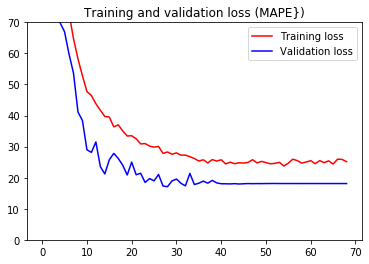

<Figure size 432x288 with 0 Axes>

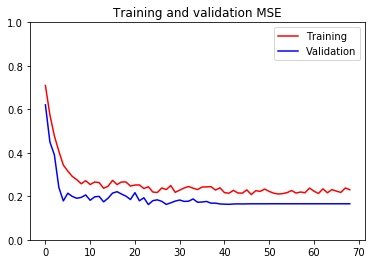

<Figure size 432x288 with 0 Axes>

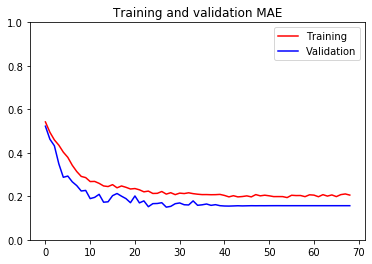

<Figure size 432x288 with 0 Axes>

In [16]:
#look at the metrics from training
%matplotlib inline

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.ylim(0,70)

plt.title('Training and validation loss (MAPE})')
plt.legend(loc=0)
plt.figure()
plt.show()

mse = history.history['mse']
val_mse = history.history['val_mse']

plt.plot(epochs, mse, 'r', label='Training')
plt.plot(epochs, val_mse, 'b', label='Validation')
plt.ylim(0,1)

plt.title('Training and validation MSE')
plt.legend(loc=0)
plt.figure()
plt.show()

mae = history.history['mae']
val_mae = history.history['val_mae']

plt.plot(epochs, mae, 'r', label='Training')
plt.plot(epochs, val_mae, 'b', label='Validation')
plt.ylim(0,1)

plt.title('Training and validation MAE')
plt.legend(loc=0)
plt.figure()
plt.show()



In [17]:
#evaluate full model on val* set:
model.evaluate(validation_generator)

18/18 [==============================] - 1s 40ms/step - loss: 17.0949 - mae: 0.1538 - mse: 0.1701


[17.094919204711914, 0.15380612015724182, 0.17011228203773499]

In [18]:
# #Full model finetune
# base_model.trainable = True

# #compile
# model.compile(loss = tf.keras.losses.MeanAbsolutePercentageError(), 
#               optimizer=tf.keras.optimizers.RMSprop(lr = 1e-9), 
#               metrics = [MAE, MSE]
#              )

# #train the model
# history = model.fit(train_generator,
#                     validation_data = validation_generator,
#                     epochs= 200,
#                     workers = 24,
#                     callbacks =[early_stop, reduce_lr])

# #look at the metrics from training
# %matplotlib inline

# loss = history.history['loss']
# val_loss = history.history['val_loss']

# epochs = range(len(loss))

# plt.plot(epochs, loss, 'r', label='Training loss')
# plt.plot(epochs, val_loss, 'b', label='Validation loss')
# plt.ylim(0,70)

# plt.title('Training and validation loss (MAPE})')
# plt.legend(loc=0)
# plt.figure()
# plt.show()

# mse = history.history['mse']
# val_mse = history.history['val_mse']

# plt.plot(epochs, mse, 'r', label='Training')
# plt.plot(epochs, val_mse, 'b', label='Validation')
# plt.ylim(0,1)

# plt.title('Training and validation MSE')
# plt.legend(loc=0)
# plt.figure()
# plt.show()

# mae = history.history['mae']
# val_mae = history.history['val_mae']

# plt.plot(epochs, mae, 'r', label='Training')
# plt.plot(epochs, val_mae, 'b', label='Validation')
# plt.ylim(0,1)

# plt.title('Training and validation MAE')
# plt.legend(loc=0)
# plt.figure()
# plt.show()

# #evaluate full model on val* set:
# model.evaluate(validation_generator)

Stats : [0.1949     0.22274167 0.250625   0.27608077 0.30843824 0.38924286
 0.5007     0.57755    0.6661     0.81248333 1.00335   ]
Predicted Stats: [[0.13988629 0.17916976 0.19213675 0.22398415 0.2339147  0.3000444
  0.40843937 0.38745886 0.47258255 0.5945404  0.6232633 ]]


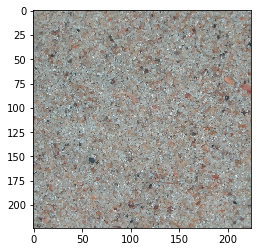

In [19]:
# use the validation generator as a sanity check

x = validation_generator.next()

how_many = 1
#how_many = batch_size

for i in range(0,how_many):
    image = x[0][i]   # batch[0] images, batch[1] labels... 
    #make a prediction
    img = np.expand_dims(image,axis=0)
    predStats = model.predict(img)
    
    plt.imshow(image.squeeze())   #squeeze for grayscale images  
    print('Stats :',x[1][i])
    print('Predicted Stats:', predStats)
    plt.show()

In [20]:
#save the model
filepath = './models/SNmodel_MN2_Dec14'
model.save(filepath)


INFO:tensorflow:Assets written to: ./models/SNmodel_MN2_Dec14/assets


In [21]:
#reload model, if needed
model = tf.keras.models.load_model(filepath)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                             

 block_3_expand_relu (ReLU)     (None, 56, 56, 144)  0           ['block_3_expand_BN[0][0]']      
                                                                                                  
 block_3_pad (ZeroPadding2D)    (None, 57, 57, 144)  0           ['block_3_expand_relu[0][0]']    
                                                                                                  
 block_3_depthwise (DepthwiseCo  (None, 28, 28, 144)  1296       ['block_3_pad[0][0]']            
 nv2D)                                                                                            
                                                                                                  
 block_3_depthwise_BN (BatchNor  (None, 28, 28, 144)  576        ['block_3_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_3_d

 lization)                                                                                        
                                                                                                  
 block_7_expand (Conv2D)        (None, 14, 14, 384)  24576       ['block_6_project_BN[0][0]']     
                                                                                                  
 block_7_expand_BN (BatchNormal  (None, 14, 14, 384)  1536       ['block_7_expand[0][0]']         
 ization)                                                                                         
                                                                                                  
 block_7_expand_relu (ReLU)     (None, 14, 14, 384)  0           ['block_7_expand_BN[0][0]']      
                                                                                                  
 block_7_depthwise (DepthwiseCo  (None, 14, 14, 384)  3456       ['block_7_expand_relu[0][0]']    
 nv2D)    

                                                                                                  
 block_10_depthwise_relu (ReLU)  (None, 14, 14, 384)  0          ['block_10_depthwise_BN[0][0]']  
                                                                                                  
 block_10_project (Conv2D)      (None, 14, 14, 96)   36864       ['block_10_depthwise_relu[0][0]']
                                                                                                  
 block_10_project_BN (BatchNorm  (None, 14, 14, 96)  384         ['block_10_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_11_expand (Conv2D)       (None, 14, 14, 576)  55296       ['block_10_project_BN[0][0]']    
                                                                                                  
 block_11_

 block_14_depthwise (DepthwiseC  (None, 7, 7, 960)   8640        ['block_14_expand_relu[0][0]']   
 onv2D)                                                                                           
                                                                                                  
 block_14_depthwise_BN (BatchNo  (None, 7, 7, 960)   3840        ['block_14_depthwise[0][0]']     
 rmalization)                                                                                     
                                                                                                  
 block_14_depthwise_relu (ReLU)  (None, 7, 7, 960)   0           ['block_14_depthwise_BN[0][0]']  
                                                                                                  
 block_14_project (Conv2D)      (None, 7, 7, 160)    153600      ['block_14_depthwise_relu[0][0]']
                                                                                                  
 block_14_

In [22]:
#quantize all layers but dense iwth not isinstance

# Helper function  to annotate all non dense layters
def apply_quantization_to_not_dense(layer):
  if not isinstance(layer, (tf.keras.layers.Dense,tf.keras.layers.Dropout)):
    return tfmot.quantization.keras.quantize_annotate_layer(layer)
  return layer

# Use `tf.keras.models.clone_model` to apply `apply_quantization_to_dense` 
# to the layers of the model.
annotated_model = tf.keras.models.clone_model(
    model,
    clone_function = apply_quantization_to_not_dense,
)


# Now that non- Dense layers are annotated,
# `quantize_apply` actually makes the model quantization aware.
quant_aware_model = tfmot.quantization.keras.quantize_apply(annotated_model)
quant_aware_model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 quantize_layer (QuantizeLayer)  (None, 224, 224, 3)  3          ['input_1[0][0]']                
                                                                                                  
 quant_Conv1 (QuantizeWrapperV2  (None, 112, 112, 32  929        ['quantize_layer[1][0]']         
 )                              )                                                                 
                                                                                              

 quant_block_2_add (QuantizeWra  (None, 56, 56, 24)  3           ['quant_block_1_project_BN[0][0]'
 pperV2)                                                         , 'quant_block_2_project_BN[0][0]
                                                                 ']                               
                                                                                                  
 quant_block_3_expand (Quantize  (None, 56, 56, 144)  3745       ['quant_block_2_add[0][0]']      
 WrapperV2)                                                                                       
                                                                                                  
 quant_block_3_expand_BN (Quant  (None, 56, 56, 144)  577        ['quant_block_3_expand[0][0]']   
 izeWrapperV2)                                                                                    
                                                                                                  
 quant_blo

 quant_block_5_add (QuantizeWra  (None, 28, 28, 32)  3           ['quant_block_4_add[0][0]',      
 pperV2)                                                          'quant_block_5_project_BN[0][0]'
                                                                 ]                                
                                                                                                  
 quant_block_6_expand (Quantize  (None, 28, 28, 192)  6529       ['quant_block_5_add[0][0]']      
 WrapperV2)                                                                                       
                                                                                                  
 quant_block_6_expand_BN (Quant  (None, 28, 28, 192)  769        ['quant_block_6_expand[0][0]']   
 izeWrapperV2)                                                                                    
                                                                                                  
 quant_blo

 quant_block_8_add (QuantizeWra  (None, 14, 14, 64)  3           ['quant_block_7_add[0][0]',      
 pperV2)                                                          'quant_block_8_project_BN[0][0]'
                                                                 ]                                
                                                                                                  
 quant_block_9_expand (Quantize  (None, 14, 14, 384)  25345      ['quant_block_8_add[0][0]']      
 WrapperV2)                                                                                       
                                                                                                  
 quant_block_9_expand_BN (Quant  (None, 14, 14, 384)  1537       ['quant_block_9_expand[0][0]']   
 izeWrapperV2)                                                                                    
                                                                                                  
 quant_blo

                                                                 ']                               
                                                                                                  
 quant_block_12_expand (Quantiz  (None, 14, 14, 576)  56449      ['quant_block_11_add[0][0]']     
 eWrapperV2)                                                                                      
                                                                                                  
 quant_block_12_expand_BN (Quan  (None, 14, 14, 576)  2305       ['quant_block_12_expand[0][0]']  
 tizeWrapperV2)                                                                                   
                                                                                                  
 quant_block_12_expand_relu (Qu  (None, 14, 14, 576)  3          ['quant_block_12_expand_BN[0][0]'
 antizeWrapperV2)                                                ]                                
          

                                                                  'quant_block_14_project_BN[0][0]
                                                                 ']                               
                                                                                                  
 quant_block_15_expand (Quantiz  (None, 7, 7, 960)   155521      ['quant_block_14_add[0][0]']     
 eWrapperV2)                                                                                      
                                                                                                  
 quant_block_15_expand_BN (Quan  (None, 7, 7, 960)   3841        ['quant_block_15_expand[0][0]']  
 tizeWrapperV2)                                                                                   
                                                                                                  
 quant_block_15_expand_relu (Qu  (None, 7, 7, 960)   3           ['quant_block_15_expand_BN[0][0]'
 antizeWra

In [23]:
#delete old model
del model
del annotated_model

In [24]:
# `quantize_model` requires a recompile.
quant_aware_model.compile(loss = tf.keras.losses.MeanAbsolutePercentageError(), 
              optimizer=tf.keras.optimizers.Adam(learning_rate = 1e-7), 
              metrics = [MAE, MSE]
             )

#retrain with low learning rate:

quant2_history = quant_aware_model.fit(train_generator,
                    validation_data = validation_generator,
                    epochs= 100,
                    workers = 8,
                    callbacks =[early_stop, reduce_lr])


Epoch 1/100
72/72 [==============================] - 23s 218ms/step - loss: 83.1232 - mae: 0.3447 - mse: 0.3240 - val_loss: 55.8824 - val_mae: 0.2796 - val_mse: 0.2127 - lr: 1.0000e-07
Epoch 2/100
72/72 [==============================] - 14s 200ms/step - loss: 62.6061 - mae: 0.3149 - mse: 0.2838 - val_loss: 39.3319 - val_mae: 0.2247 - val_mse: 0.1888 - lr: 1.0000e-07
Epoch 3/100
72/72 [==============================] - 15s 203ms/step - loss: 49.9682 - mae: 0.2835 - mse: 0.2816 - val_loss: 34.7653 - val_mae: 0.2023 - val_mse: 0.1819 - lr: 1.0000e-07
Epoch 4/100
72/72 [==============================] - 15s 206ms/step - loss: 47.3548 - mae: 0.2657 - mse: 0.2500 - val_loss: 31.2493 - val_mae: 0.1961 - val_mse: 0.2010 - lr: 1.0000e-07
Epoch 5/100
72/72 [==============================] - 15s 207ms/step - loss: 43.2395 - mae: 0.2576 - mse: 0.2508 - val_loss: 28.0751 - val_mae: 0.1860 - val_mse: 0.1961 - lr: 1.0000e-07
Epoch 6/100
72/72 [==============================] - 15s 209ms/step - loss:

Epoch 42/100
72/72 [==============================] - 16s 220ms/step - loss: 29.9352 - mae: 0.2372 - mse: 0.2738 - val_loss: 20.7259 - val_mae: 0.1859 - val_mse: 0.2224 - lr: 1.6000e-10
Epoch 43/100
72/72 [==============================] - 16s 220ms/step - loss: 30.5298 - mae: 0.2385 - mse: 0.2735 - val_loss: 20.8897 - val_mae: 0.1871 - val_mse: 0.2229 - lr: 1.6000e-10
Epoch 44/100
72/72 [==============================] - 16s 222ms/step - loss: 29.9662 - mae: 0.2338 - mse: 0.2709 - val_loss: 21.5243 - val_mae: 0.1889 - val_mse: 0.2217 - lr: 1.6000e-10
Epoch 45/100
72/72 [==============================] - 16s 220ms/step - loss: 30.2425 - mae: 0.2380 - mse: 0.2757 - val_loss: 21.5554 - val_mae: 0.1895 - val_mse: 0.2234 - lr: 1.6000e-10
Epoch 46/100
72/72 [==============================] - ETA: 0s - loss: 30.3815 - mae: 0.2390 - mse: 0.2730
Epoch 46: ReduceLROnPlateau reducing learning rate to 3.199999709657675e-11.
72/72 [==============================] - 16s 220ms/step - loss: 30.3815 -

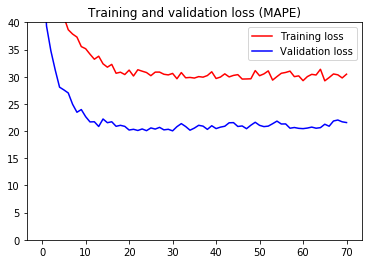

<Figure size 432x288 with 0 Axes>

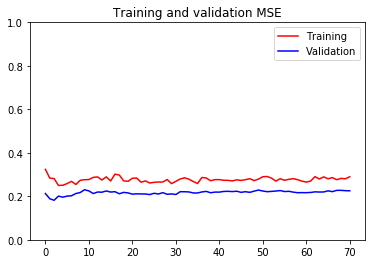

<Figure size 432x288 with 0 Axes>

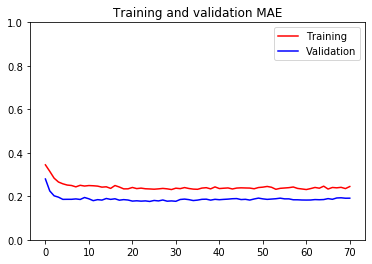

<Figure size 432x288 with 0 Axes>

In [25]:
#look at the metrics from QAT 
%matplotlib inline

loss = quant2_history.history['loss']
val_loss = quant2_history.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.ylim(0,40)

plt.title('Training and validation loss (MAPE)')
plt.legend(loc=0)
plt.figure()
plt.show()

mse = quant2_history.history['mse']
val_mse = quant2_history.history['val_mse']

plt.plot(epochs, mse, 'r', label='Training')
plt.plot(epochs, val_mse, 'b', label='Validation')
plt.ylim(0,1)

plt.title('Training and validation MSE')
plt.legend(loc=0)
plt.figure()
plt.show()

mae = quant2_history.history['mae']
val_mae = quant2_history.history['val_mae']

plt.plot(epochs, mae, 'r', label='Training')
plt.plot(epochs, val_mae, 'b', label='Validation')
plt.ylim(0,1)

plt.title('Training and validation MAE')
plt.legend(loc=0)
plt.figure()
plt.show()

In [26]:
#evaluate full model on val set:
quant_aware_model.evaluate(validation_generator)

18/18 [==============================] - 1s 54ms/step - loss: 20.0451 - mae: 0.1771 - mse: 0.2083


[20.045127868652344, 0.17711204290390015, 0.20832519233226776]

Stats : [0.14005    0.15426667 0.16772857 0.17898571 0.19223333 0.22373594
 0.26298043 0.28568235 0.30855    0.34166429 0.38105   ]
Predicted Stats: [[0.11570212 0.12178238 0.17215905 0.18250091 0.18791099 0.22194296
  0.28544077 0.40625864 0.44320917 0.4265731  0.58577216]]


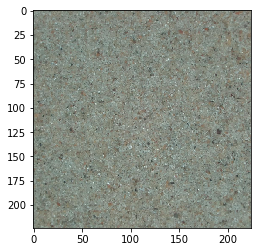

In [27]:
# use the validation generator as a sanity check

x = validation_generator.next()

how_many = 1
#how_many = batch_size

for i in range(0,how_many):
    image = x[0][i]   # batch[0] images, batch[1] labels... 
    #make a prediction
    img = np.expand_dims(image,axis=0)
    predStats = quant_aware_model.predict(img)
    
    plt.imshow(image.squeeze())   #squeeze for grayscale images  
    print('Stats :',x[1][i])
    print('Predicted Stats:', predStats)
    plt.show()

In [28]:
#TF lite converter for the QAT model
#converter = tf.lite.TFLiteConverter.from_keras_model(quant_aware_model)
#converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter = tf.lite.TFLiteConverter.from_saved_model(filepath)

converter.optimizations = [tf.lite.Optimize.DEFAULT]

quantized_tflite_model2 = converter.convert()


tflite_models_dir = pathlib.Path("TFL_models/")
tflite_models_dir.mkdir(exist_ok=True, parents=True)
tflite_model_file = tflite_models_dir/"SandCam_MNv2_QAT_notdense_dec14.tflite"
tflite_model_file.write_bytes(quantized_tflite_model2)

!ls -lh {tflite_models_dir}

total 17M
drwxrwxr-x 2 ebgoldstein ebgoldstein 4.0K Dec 14 12:22 dev
-rw-rw-r-- 1 ebgoldstein ebgoldstein 3.2M Aug 27 14:14 SandCam_MNv2_QAT_notdense_aug27.tflite
-rw-rw-r-- 1 ebgoldstein ebgoldstein 3.2M Dec 14 13:04 SandCam_MNv2_QAT_notdense_dec14.tflite
-rw-rw-r-- 1 ebgoldstein ebgoldstein  794 Aug 11 09:29 SandCam_MNv2_QAT_notdense_edgetpu.log
-rw-rw-r-- 1 ebgoldstein ebgoldstein 5.3M Aug 11 09:29 SandCam_MNv2_QAT_notdense_edgetpu.tflite
-rw-rw-r-- 1 ebgoldstein ebgoldstein 5.2M Aug 11 09:29 SandCam_MNv2_QAT_notdense.tflite


In [29]:
#Load QAT model into TFlite intepreter
interpreter = tf.lite.Interpreter(model_path=str(tflite_model_file))
interpreter.allocate_tensors()

Stats : [0.1608     0.17755    0.1946     0.20927059 0.22781905 0.27765
 0.34459    0.38058    0.4147     0.46044167 0.51968333]
Predicted Stats: [[0.14440349 0.19156763 0.1934845  0.22250503 0.263021   0.2839502
  0.39397433 0.39495468 0.42553228 0.54904836 0.57364094]]


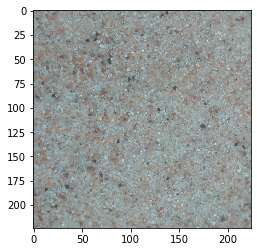

In [30]:
#Sanity check on image 

#SET THE IMAGE
Timage = validation_generator.next()
test_image = np.expand_dims(Timage[0][1],axis=0)

#dynamic range quant
input_index = interpreter.get_input_details()[0]["index"]
output_index = interpreter.get_output_details()[0]["index"]

interpreter.set_tensor(input_index, test_image)
interpreter.invoke()
predictionsQAT = interpreter.get_tensor(output_index)

plt.imshow(Timage[0][1])

print('Stats :',Timage[1][1])
print('Predicted Stats:', predictionsQAT)

plt.grid(False)

In [31]:
testdf = df
test_data_dir = '../data/CropPics'
testdf = testdf.reset_index()  # make sure indexes pair with number of rows
testdf.head()

,index,CropName,D2mm,D5mm,D10mm,D16mm,D25mm,D50mm,D75mm,D84mm,D90mm,D95mm,D98mm,Skew,kurtosis
0,610,QZOUX/crop6.jpg,0.194900,0.222742,0.250625,0.276081,0.308438,0.389243,0.500700,0.577550,0.666100,0.812483,1.003350,0.103262,1.094691
1,494,COJVI/crop38.jpg,0.158800,0.182940,0.208239,0.233060,0.269604,0.407480,0.853900,1.351600,1.884721,2.712070,3.660125,0.385141,0.958525
2,284,F7crop35.jpg,0.150200,0.166400,0.181386,0.194100,0.209469,0.247073,0.295695,0.323725,0.351517,0.390633,0.444967,0.065038,1.014471
3,271,F7crop22.jpg,0.169525,0.188638,0.207383,0.224125,0.244795,0.298660,0.363564,0.397828,0.430050,0.473936,0.529467,0.000904,0.954556
4,177,F6crop28.jpg,0.184300,0.210608,0.237000,0.260818,0.291059,0.366779,0.469997,0.535750,0.611836,0.726600,0.889000,0.078404,1.059121


In [32]:
#Load QAT model into TFlite intepreter
tflite_models_dir = pathlib.Path("TFL_models/")
tflite_model_file = tflite_models_dir/"SandCam_MNv2_QAT_notdense_dec14.tflite"
interpreter = tf.lite.Interpreter(model_path=str(tflite_model_file))
interpreter.allocate_tensors()

Stats : [0.1588 0.18294000000000002 0.208238888888889 0.23306 0.269604166666667
 0.40748 0.8539 1.3516 1.8847214285714298 2.71207]
Predicted Stats: [[0.11746241 0.13439849 0.14594385 0.1606474  0.21377707 0.265818
  0.33867797 0.4096339  0.45360875 0.48812416 0.5888988 ]]


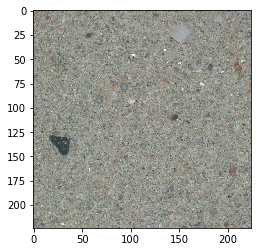

In [33]:
#Sanity check on a single image 
pix_dim = 224
imsize = (pix_dim, pix_dim) 

#SET THE IMAGE
imgp = "../data/CropPics/F7crop21.jpg"
img = tf.keras.preprocessing.image.load_img(imgp,target_size = imsize)
img = tf.keras.preprocessing.image.img_to_array(img)
img = img/255
test_image = np.expand_dims(img,axis=0)

#set up tensors and rpedict
input_index = interpreter.get_input_details()[0]["index"]
output_index = interpreter.get_output_details()[0]["index"]

interpreter.set_tensor(input_index, test_image)
interpreter.invoke()
predictionsQAT = interpreter.get_tensor(output_index)

#show results
plt.imshow(img)

print('Stats :', testdf.iloc[1,2:12].values )
print('Predicted Stats:', predictionsQAT)

plt.grid(False)

In [34]:
#Evaluate on all images:
# 1. loop over all rows in data frame
# 2. grab image path
# 3. evaluate image w/ TFLite
# 4. write output to df
# 5. make plot

# fn to do tflite prediction
def TFLitePred (imgpath):
    pix_dim = 224
    imsize = (pix_dim, pix_dim) 
    #SET THE IMAGE
    img = tf.keras.preprocessing.image.load_img(imgpath,target_size = imsize)
    img = tf.keras.preprocessing.image.img_to_array(img)
    img = img/255
    test_image = np.expand_dims(img,axis=0)

    #set up tensors and rpedict
    input_index = interpreter.get_input_details()[0]["index"]
    output_index = interpreter.get_output_details()[0]["index"]

    interpreter.set_tensor(input_index, test_image)
    interpreter.invoke()
    predictionsQAT = interpreter.get_tensor(output_index)
    
    return predictionsQAT
    

In [35]:
#mmake an empty dictionary to hold predictions
pred_dict = []

## loop over all rows in data frame, grab image path, evaluate image w/ TFLite helper fn, 
# then flatten results adn append ot the dictionary
for index, row in testdf.iterrows():
    imgpath = "../data/CropPicsAll/" + row['CropName']
    pred = TFLitePred (imgpath).flatten()
    pred_dict.append(pred)
    #print(pred)

#turn dicitonary into dataframe, add columns, and add to the test df
predictions = pd.DataFrame.from_dict(pred_dict)
predictions.columns=["pD2mm", "pD5mm", "pD10mm", "pD16mm",
"pD25mm","pD50mm", "pD75mm", "pD84mm", "pD90mm",
"pD95mm", "pD98mm"]
predictions.head()

testdf = testdf.join(predictions)

testdf.head()

,index,CropName,D2mm,D5mm,D10mm,D16mm,D25mm,D50mm,D75mm,D84mm,...,pD5mm,pD10mm,pD16mm,pD25mm,pD50mm,pD75mm,pD84mm,pD90mm,pD95mm,pD98mm
0,610,QZOUX/crop6.jpg,0.194900,0.222742,0.250625,0.276081,0.308438,0.389243,0.500700,0.577550,...,0.192069,0.206816,0.248786,0.271256,0.328337,0.452291,0.447986,0.519449,0.638614,0.669741
1,494,COJVI/crop38.jpg,0.158800,0.182940,0.208239,0.233060,0.269604,0.407480,0.853900,1.351600,...,0.140851,0.224643,0.249715,0.230222,0.360498,0.540992,0.594150,0.726392,0.849188,1.055534
2,284,F7crop35.jpg,0.150200,0.166400,0.181386,0.194100,0.209469,0.247073,0.295695,0.323725,...,0.170664,0.195682,0.206274,0.221283,0.276359,0.357130,0.420883,0.478231,0.524813,0.600129
3,271,F7crop22.jpg,0.169525,0.188638,0.207383,0.224125,0.244795,0.298660,0.363564,0.397828,...,0.187258,0.189887,0.224734,0.253166,0.301133,0.412620,0.397216,0.460267,0.551357,0.561249
4,177,F6crop28.jpg,0.184300,0.210608,0.237000,0.260818,0.291059,0.366779,0.469997,0.535750,...,0.202707,0.241800,0.295280,0.329786,0.455207,0.549242,0.574427,0.703841,0.799801,0.804588


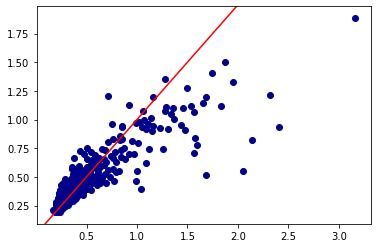

In [44]:
import matplotlib.lines as mlines

x = testdf.D50mm
y = testdf.pD50mm

fig, ax1 = plt.subplots()
ax1.scatter(x,y,c='DarkBlue')
line = mlines.Line2D([0, 6], [0, 6], color='red')

ax1.add_line(line)

In [45]:
testdf.to_csv('ALLPredsDec14.csv')